In [2]:
import pandas as pd
import numpy as np
import os.path
import datetime
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
import scipy.stats as stats
from scipy.stats import loguniform
import sys
from sklearn.model_selection import StratifiedShuffleSplit
import os
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support
from imblearn.over_sampling import SVMSMOTE
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE
import os.path
from openpyxl import Workbook, load_workbook
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'white'
np.set_printoptions(threshold=sys.maxsize, suppress=True)

In [3]:
datatypes = {'business_area': str, 'sex': str, 'employment_status': str,
            'time': str, 'severity': str, 'enterprise_size': str,
            'citizenship': str, 'profession_code': str, 'type_of_injury': str
            , 'injured_bodypart': str, 'workstation': str,
            'working_environment': str, 'working_process': str
            , 'specific_physical_activity': str,
            'material_agent_of_physical_act.': str,
            'deviation': str, 'material_agent_of_deviation': str
            , 'contact_mode_of_injury': str, 'material_agent_of_contact_mode': str, 'general_profession_code': str, 'month': str, 'weekofyear': str, 'dayofweek': str, 'material_agent_of_physical_act': str}

In [4]:
# For reproducing results use data.csv in your working directory and comment the fist line out
os.chdir('/Users/Mario/OneDrive - Tartu Ülikool/IT_mitteinformaatikutele_MSc/Magistritöö/Final code for thesis')
df = pd.read_csv('data.csv', dtype = datatypes, encoding='latin-1', index_col=0)
df = df.drop(columns= ['date', 'time', 'datetime', 'time_ESAW', 'lost_days', 'type_of_injury', 'injured_bodypart', 'severity'])

In [5]:
sector = 'G'
occup_class = 7
df = df[(df['business_sector'] == sector)].copy()
df = df[(df['general_profession_class'] == occup_class)].copy()
df = df.drop(columns=['business_sector', 'general_profession_class'])
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
# G7 hand-picked (important) features
df = df[['business_area', 'age', 'full_hours_from_startofwork', 'location', 'citizenship', 'profession_code', 'working_process', 'specific_physical_activity', 'material_agent_of_physical_act', 'deviation', 'material_agent_of_deviation', 'contact_mode_of_injury', 'material_agent_of_contact_mode', 'enterprise_size_ordinal_enc', 'dayofweek', 'month', 'sin_time', 'cos_time', 'temperature', 'cause code 001', 'cause code 002', 'cause code 003', 'cause code 004', 'cause code 005', 'cause code 006', 'cause code 008', 'cause code 009', 'cause code 011', 'cause code 014', 'cause code 025', 'target']]

In [7]:
all_object_cols = list(df.select_dtypes(include=['object']).columns)
df = pd.get_dummies(df, columns=all_object_cols)


X = df.drop(columns=['target'])
y = df['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


float_cols = X_train.select_dtypes(include='float64').columns.tolist()
scaler = MinMaxScaler(feature_range=(0,1))
X_train[float_cols] = scaler.fit_transform(X_train[float_cols])
X_test[float_cols] = scaler.transform(X_test[float_cols])

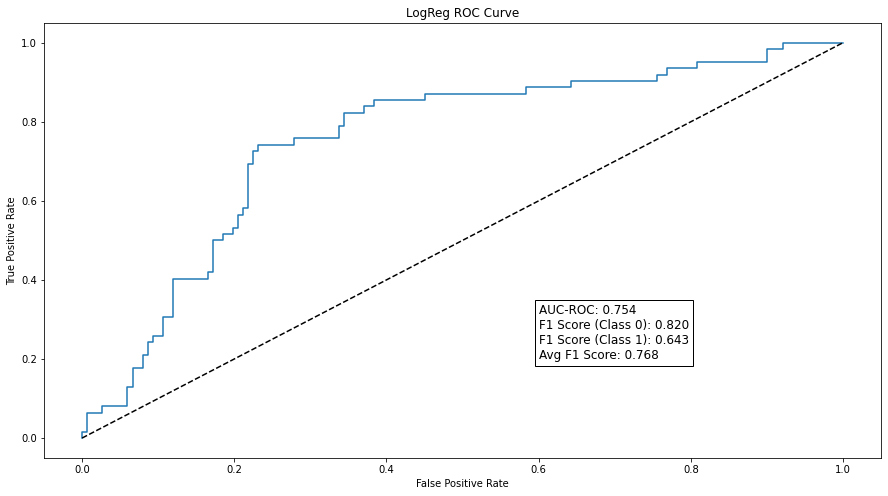

['age', 'cause code 005', 'cause code 008', 'full_hours_from_startofwork', 'contact_mode_of_injury_60']


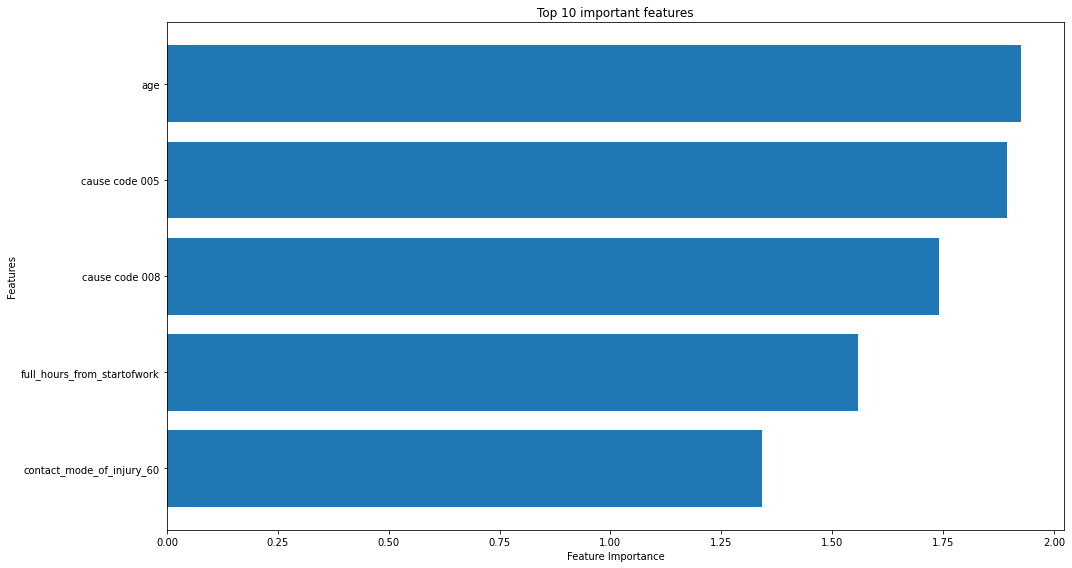

In [8]:
rs = 42
over_sampler = RandomOverSampler(random_state=rs)
X_train, y_train = over_sampler.fit_resample(X_train, y_train)


rf_model = RandomForestClassifier(random_state=rs)
lgbm_model = LGBMClassifier(random_state=rs)
xgb_model = xgb.XGBClassifier(random_state=rs)
svm_model = SVC(kernel='rbf', probability=True, random_state=rs)
lr_model = LogisticRegression(max_iter=1000, random_state=rs, multi_class="ovr")

model = lr_model

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)   
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
f1_class_0 = f1_score(y_test, y_pred, pos_label=0)
f1_class_1 = f1_score(y_test, y_pred, pos_label=1)
avg_f1 = f1_score(y_test, y_pred, average='weighted')


precision_class_0 = precision_score(y_test, y_pred, pos_label=0)
precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
recall_class_1 = recall_score(y_test, y_pred, pos_label=1)

plt.figure(figsize=(15, 8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogReg ROC Curve')
plt.text(0.6, 0.2, f"AUC-ROC: {auc_roc:.3f}\nF1 Score (Class 0): {f1_class_0:.3f}\nF1 Score (Class 1): {f1_class_1:.3f}\nAvg F1 Score: {avg_f1:.3f}", fontsize=12, bbox=dict(facecolor='white'))
plt.show()


importance = abs(lr_model.coef_[0])
feature_names = X_train.columns

indices = np.argsort(importance)[::-1][:5]
top_features = [feature_names[i] for i in indices]
top_importance = importance[indices]


print(top_features)

plt.figure(figsize=(15, 8))
plt.title("Top 10 important features")
plt.barh(top_features, top_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis() 
plt.tight_layout() 
plt.show()